# Deep Learning Coursework

### Group Members: Dean Yang, Alek Dimitrov, Mingyuan Xia

# Imports

In [1]:
# Pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Pipeline, preprocessing, and train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer  # Fill in missing values
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Model and feature selection
import xgboost as xgb
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor, 
)

from sklearn.linear_model import (
    LogisticRegression
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, Dense, LSTM, SimpleRNN, Bidirectional, Dropout

from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB, ComplementNB,  CategoricalNB

# Data Processing

In [2]:
# read the data
data = pd.read_csv("Data_A.csv", header=None)
X_B = pd.read_csv("Data_B_nolabels.csv", header=None)

data.columns = [str(i) for i in range(len(data.columns))]
rows, columns = data.shape

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1,693200.0,126,692800.0,110,693300.0,50,692700.0,165,693400.0,...,50,693500.0,50,692500.0,250,0,1,0,1,0
1,0,650400.0,501,650200.0,106,650500.0,245,650100.0,259,650600.0,...,328,650700.0,141,649900.0,277,0,0,1,1,1
2,1,636200.0,153,635800.0,150,636300.0,100,635700.0,15,636400.0,...,110,636500.0,105,635500.0,201,0,1,0,1,0
3,0,724800.0,4,724500.0,14,724900.0,50,724300.0,312,725100.0,...,100,725200.0,379,724100.0,56,1,0,0,1,1
4,0,622900.0,110,622700.0,100,623000.0,523,622600.0,300,623100.0,...,249,623200.0,605,622400.0,200,1,0,1,1,0


In [4]:
# split the dataset into dependent and independent variables
X, Y = data.drop(columns=["0"]), data["0"]

In [5]:
X_B.columns = X.columns

In [6]:
# X.drop(columns=[str(i) for i in [3, 5, 7, 9, 11, 13, 15]], inplace=True)  # lets drop highly correlated features

In [7]:
# Standardize the data
for i in range(len(X.columns)-5):
    std = pd.concat([X.iloc[:,i], X_B.iloc[:,i]]).std()
    mean = pd.concat([X.iloc[:,i], X_B.iloc[:,i]]).mean()
    X.iloc[:,i] = (X.iloc[:,i] - mean) / std
    X_B.iloc[:,i] = (X_B.iloc[:,i] - mean) / std

In [8]:
print("Y has {} '1' labels".format(len(Y[Y == 1])))
print("Y has {} '0' labels".format(len(Y[Y == 0])))

Y has 100008 '1' labels
Y has 99992 '0' labels


Note: Y has balanced labels '0' and '1'.

In [9]:
X_train_large, X_test, Y_train_large, Y_test = train_test_split(X, Y, test_size=0.2)

X_train, X_val, Y_train, Y_val = train_test_split(X_train_large, Y_train_large, test_size=0.2)

# Overview: 

The general approach of this coursework is to generate several input models first (including logistic regression, random forest, multilayer perceptron, inception models etc.), and then feed those continuous predictions from input models to a final one-layer neural network to make the final predictions. <br>

We split dataset A into training set, validation set and test set, use the validation set to select hyperparameters for all models (including both input models and final mlp model), retrain the stacked model on both training set and validation set, and then test its performance on the test set and generate predictions on dataset B.

# Input Models



### Input model 1: Logistic Regression

In [12]:
model_lr = Pipeline([
    ('logistic', LogisticRegression())
])

In [13]:
# Train the model using the pipeline
model_lr.fit(X_train, Y_train) 

# Make predictions
predictions_lr = model_lr.predict(X_val)

# Evaluate the model
print(confusion_matrix(Y_val, predictions_lr))
print(classification_report(Y_val, predictions_lr))

[[10786  5261]
 [ 5403 10550]]
              precision    recall  f1-score   support

           0       0.67      0.67      0.67     16047
           1       0.67      0.66      0.66     15953

    accuracy                           0.67     32000
   macro avg       0.67      0.67      0.67     32000
weighted avg       0.67      0.67      0.67     32000



In [14]:
# test its performance on train_val set (not used for training)
accuracy = accuracy_score(Y_val, predictions_lr)
print("Accuracy:", accuracy)

Accuracy: 0.66675


### Input model 2: Random Forest

Select the best hyper-parameters(number of trees and maximum depths of trees) for random forest.

In [110]:
# Performa a grid search to select the best hyper-parameters
number_of_trees = [100, 250, 500]
max_depths = [15, 20, 30]  
accuracy_scores = np.zeros((len(number_of_trees), len(max_depths)))
for i, n in enumerate(number_of_trees):
    for j, depth in enumerate(max_depths):
        model_rf = Pipeline([('logistic', RandomForestClassifier(n_estimators=n, max_depth = depth))])
        model_rf.fit(X_train, Y_train)
        predictions_rf = model_rf.predict(X_val)
        accuracy_scores[i, j] = accuracy_score(Y_val, predictions_rf)
        print("Accuracy for {} trees with max depth {}: {}".format(n,depth, accuracy_score(Y_val, predictions_rf)))

Accuracy for 100 trees with max depth 15: 0.72853125
Accuracy for 100 trees with max depth 20: 0.7254375
Accuracy for 100 trees with max depth 30: 0.722875
Accuracy for 250 trees with max depth 15: 0.72815625
Accuracy for 250 trees with max depth 20: 0.7283125
Accuracy for 250 trees with max depth 30: 0.7268125
Accuracy for 500 trees with max depth 15: 0.7289375
Accuracy for 500 trees with max depth 20: 0.72884375
Accuracy for 500 trees with max depth 30: 0.72671875


In [111]:
# find the best hyper-parameters with the highest accuracy on the sub_validation set
max_index = np.unravel_index(np.argmax(accuracy_scores), accuracy_scores.shape)
best_n = number_of_trees[max_index[0]]
best_depth = max_depths[max_index[1]]

#print
print("Best number of trees: {}".format(best_n))
print("Best max depth: {}".format(best_depth))

Best number of trees: 500
Best max depth: 15


In [15]:
best_n = 500
best_depth = 15

# Retrain the model on the entire training set with the best hyperparameters
model_rf = Pipeline([('rf', RandomForestClassifier(n_estimators=best_n, max_depth = best_depth))])
model_rf.fit(X_train, Y_train)

Pipeline(steps=[('rf', RandomForestClassifier(max_depth=15, n_estimators=500))])

### Input Model 3: KNN

In [113]:
# Select the best hyper-parameters n
n_neighbors = [5, 10, 15, 20, 25, 30, 35, 40]
accuracy_scores = np.zeros(len(n_neighbors))
for n in n_neighbors:
    model_knn = Pipeline([
        ('scaler', StandardScaler()), 
        ('knn', KNeighborsClassifier(n_neighbors=n))
    ])
    model_knn.fit(X_train, Y_train)
    predictions_knn = model_knn.predict(X_val)
    accuracy_scores[n_neighbors.index(n)] = accuracy_score(Y_val, predictions_knn)
    print("Accuracy for {} neighbors: {}".format(n, accuracy_scores[n_neighbors.index(n)]))

Accuracy for 5 neighbors: 0.64428125
Accuracy for 10 neighbors: 0.6554375
Accuracy for 15 neighbors: 0.6633125
Accuracy for 20 neighbors: 0.66528125
Accuracy for 25 neighbors: 0.66775
Accuracy for 30 neighbors: 0.66790625
Accuracy for 35 neighbors: 0.6693125
Accuracy for 40 neighbors: 0.6693125


In [114]:
# find the best hyper-parameters with the highest accuracy on the sub_validation set
index = np.argmax(accuracy_scores)
best_n = n_neighbors[index]

print("Best number of neighbors: {}".format(best_n))

Best number of neighbors: 35


In [16]:
best_n = 35

# Retrain the model on the entire training set with the best hyperparameters
model_knn = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', KNeighborsClassifier(n_neighbors=best_n))
])
model_knn.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=30))])

### Input model 4: Naive-Bayesian 

In [116]:
# Try two different types of Naive Bayes
type_NB = [BernoulliNB, GaussianNB]
accuracy_scores = np.zeros(len(type_NB))
for i, t in enumerate(type_NB):
    model_nb = t()
    model_nb.fit(X_train, Y_train)
    predictions_nb = model_nb.predict(X_val)
    accuracy_scores[i] = accuracy_score(Y_val, predictions_nb)
    print("Accuracy for {}: {}".format(t, accuracy_scores[i]))


Accuracy for <class 'sklearn.naive_bayes.BernoulliNB'>: 0.63878125
Accuracy for <class 'sklearn.naive_bayes.GaussianNB'>: 0.5739375


In [117]:
#retrain the model on the entire training set
model_nb = BernoulliNB()
model_nb.fit(X_train, Y_train)


BernoulliNB()

### Input model 5: XGBoost Model

In [165]:
def grid_search(x, y, x_valid, y_valid, learning_rate_list = np.logspace(-5, 0, 5), 
                    n_list = [50, 100, 250, 500], 
                    subsample_list = [0.5, 0.65,  0.8,  1]):
    
    """
    param x: the training set descriptors, dataframe or numpy array
    param y: the training set target values, dataframe or numpy array
    param x_valid: the validation set descriptors, dataframe or numpy array
    param y_valid: the validation set target values, dataframe or numpy array
    param learning_rate_list: the list of learning rate to be searched, list
    param n_list: the list of number of trees to be searched, list
    param subsample_list: the list of subsample rate to be searched, list
    param return_mse: whether to return the MSE list, boolean
    
    return opti_lr: the optimal learning rate, float
    return opti_n: the optimal number of trees, int
    return opti_subsample: the optimal subsample rate, float
    return MSE_list: the MSE list(training set) for all combinations of hyper-parameters, numpy array,
                        only returned when return_mse = True
    return MSE_validation_list: the MSE list(validation set) for all combinations of hyper-parameters,
                        umpy array, only returned when return_mse = True
    """
    
    # initialize the MSE list
    accuracy_validation_list =  np.zeros((len(learning_rate_list),len(n_list),len(subsample_list)))

    for i in range(len(learning_rate_list)):
        lr = learning_rate_list[i]
        for j in range(len(n_list)):
            n = n_list[j]
            for k in range(len(subsample_list)):
                
                subsample_rate = subsample_list[k]
                # train the xgb model with x and y 
                xgb_model = xgb.XGBRegressor(learning_rate = lr, n_estimators = n, 
                                        subsample = subsample_rate, random_state = 1).fit(x,y)
                # predict the y value for validation set
                y_pred_valid = xgb_model.predict(x_valid)
                # calculate the MSE for validation set
                y_pred_valid[y_pred_valid > 0.5 ] = int(1)
                y_pred_valid[y_pred_valid <= 0.5 ] = int(0)     
                accuracy_validation_list[i,j,k] = accuracy_score(y_valid, y_pred_valid)

    # find the optimal learning rate, number of trees and subsample rate
    index = np.argwhere(accuracy_validation_list == np.max(accuracy_validation_list)).reshape(3)
    opti_lr = learning_rate_list[index[0]]
    opti_n = n_list[index[1]]
    opti_subsample = subsample_list[index[2]]

    return opti_lr, opti_n, opti_subsample, accuracy_validation_list


In [166]:
opti_lr, opti_n, opti_subsample, accuracy_validation_list = grid_search(X_train, Y_train, X_val, Y_val)

print("The optimal learning rate is: {}".format(opti_lr))
print("The optimal number of trees is: {}".format(opti_n))
print("The optimal subsample rate is: {}".format(opti_subsample))

The optimal learning rate is: 0.05623413251903491
The optimal number of trees is: 500
The optimal subsample rate is: 1


In [17]:
opti_lr = 0.05623413251903491
opti_n = 500
opti_subsample = 1

model_xgb = xgb.XGBRegressor(learning_rate = opti_lr, n_estimators = opti_n, subsample = opti_subsample, random_state = 1).fit(X_train, Y_train)

# Make predictions
predictions_xgb = model_xgb.predict(X_val)
predictions_xgb[predictions_xgb > 0.5 ] = int(1)
predictions_xgb[predictions_xgb <= 0.5 ] = int(0)  


# Evaluate the model
print("Accuracy:", accuracy_score(Y_val, predictions_xgb))
print(classification_report(Y_val, predictions_xgb))

Accuracy: 0.727875
              precision    recall  f1-score   support

           0       0.73      0.73      0.73     16047
           1       0.73      0.73      0.73     15953

    accuracy                           0.73     32000
   macro avg       0.73      0.73      0.73     32000
weighted avg       0.73      0.73      0.73     32000



### Input model 6: Neural Networks

We aim to find the best 3-layer perceptrons with 128 neurons in each hidden layer that gives the highest accuracy on the validation set. We utilize the greedy algorithm: we first fix the drop-out rate as 0.5, and choose the best sequence of activation functions that gives the highest accuracy in first 300 epochs; then, we select the best drop-out rate from list [0,0.2,0.5,0.7,0.9]; finally, we select the optimal epoch given previously selected optimal activation functions and drop-out rate.

We will use Sigmoid as the activation function of the output layer as the true label are '0' and '1' and the prediction should be in the range $(0,1)$.  <br>
For the activations function of two hidden layers, we select it from tanh, ReLU, ELU, Softplus, and sigmoid.

In [ ]:
activation_function = ['relu', 'tanh', 'sigmoid', 'elu', 'softplus']
accuracy_scores = np.zeros((len(activation_function), len(activation_function)))
for i, acti1 in enumerate(activation_function):
    for j, acti2 in enumerate(activation_function):
        model_nn_input = Sequential([
            Dense(128, activation= acti1, input_shape=(X_train.shape[1],)),
            Dropout(0.5),
            Dense(128, activation= acti2),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        model_nn_input.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        # Train the neural network
        history = model_nn_input.fit(X_train, Y_train, validation_data=(X_val,Y_val), epochs=300, batch_size=256, verbose=True)
        accuracy_scores[i,j] = max(history.history['val_accuracy'])

In [147]:
opti_acti = [activation_function[i] for i in np.unravel_index(np.argmax(accuracy_scores), accuracy_scores.shape)]
print("The optimal activation function for the first layer is: {}".format(opti_acti[0]))
print("The optimal activation function for the second layer is: {}".format(opti_acti[1]))

The optimal activation function for the first layer is: relu
The optimal activation function for the second layer is: sigmoid


In [ ]:
opti_acti = ['relu', 'sigmoid']

#select the optimal dropout rate
dropout_rate = [0,0.2,0.5,0.7,0.9]
accuracy_scores = np.zeros(len(dropout_rate))
for i, rate in enumerate(dropout_rate):
    model_nn_input = Sequential([
        Dense(128, activation= opti_acti[0], input_shape=(X_train.shape[1],)),
        Dropout(rate),
        Dense(128, activation= opti_acti[1]),
        Dropout(rate),
        Dense(1, activation='sigmoid')
    ])
    model_nn_input.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Train the neural network
    history = model_nn_input.fit(X_train, Y_train, validation_data=(X_val,Y_val), epochs=300, batch_size=256, verbose=True)
    accuracy_scores[i] = max(history.history['val_accuracy'])

In [151]:
opti_dropout = dropout_rate[np.argmax(accuracy_scores)]
print("The optimal dropout rate is: {}".format(opti_dropout))

The optimal dropout rate is: 0.2


In [ ]:
opti_acti = ['relu', 'sigmoid']
opti_dropout = 0.2

# Select the optimal epoch
model_nn_input = Sequential([
        Dense(128, activation= opti_acti[0], input_shape=(X_train.shape[1],)),
        Dropout(opti_dropout),
        Dense(128, activation= opti_acti[1]),
        Dropout(opti_dropout),
        Dense(1, activation='sigmoid')
    ])

model_nn_input.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the neural network
history = model_nn_input.fit(X_train, Y_train, validation_data=(X_val,Y_val), epochs= 300, batch_size=256, verbose=True)

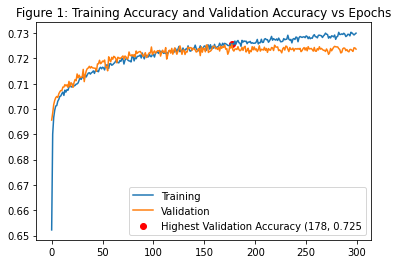

Epoch with highest validation accuracy: 178


In [168]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
max_point = np.argmax(val_accuracy)

plt.plot(range(len(accuracy)), accuracy, label='Training')
plt.plot(range(len(val_accuracy)), val_accuracy, label='Validation')
plt.scatter(max_point, val_accuracy[max_point], color='red', label=f'Highest Validation Accuracy ({max_point + 1}, {round(val_accuracy[max_point], 3)}')
plt.legend()
plt.title('Figure 1: Training Accuracy and Validation Accuracy vs Epochs')
plt.show()
print('Epoch with highest validation accuracy:', max_point + 1)


In [ ]:
#retrain the model
opti_epoch = 178
opti_acti = ['relu', 'sigmoid']
opti_dropout = 0.2

# Select the optimal epoch
model_nn_input = Sequential([
        Dense(128, activation= opti_acti[0], input_shape=(X_train.shape[1],)),
        Dropout(opti_dropout),
        Dense(128, activation= opti_acti[1]),
        Dropout(opti_dropout),
        Dense(1, activation='sigmoid')
    ])

model_nn_input.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the neural network
history = model_nn_input.fit(X_train, Y_train, validation_data=(X_val,Y_val), epochs= opti_epoch, batch_size=256, verbose=True)

### Input model 7: LSTM

We can construct sequential data from the columns. From the columns we can construct 5 different sequences.

- Sell volume levels 1, 2, 3, 4
- Sell price levels 1, 2, 3, 4
- Buy volume levels 1, 2, 3, 4
- Buy price levels 1, 2, 3, 4
- Last 5 midpoint changes

From this we can pad the first 4 sequences with 0s to make them length 5. Then we get the sequence $X_1, X_2, ..., X_5$ where $X_t \in \mathbb{R}^5$. We join the 5 vectors together to get a 5 by 5 matrix A, which will be our input. Our training data will have shape $({num\_samples}, 5, 5)$.

We use an LSTM to take advantage of the sequential structure of the order book, and the time series of the last 5 midpoint changes.

In [19]:
def partition_features(X):
    level1 = X.iloc[:, [0, 4, 8, 12]]  # Sell prices
    level2 = X.iloc[:, [1, 5, 9, 13]]  # Sell vols
    level3 = X.iloc[:, [2, 6, 10, 14]]  # Buy prices
    level4 = X.iloc[:, [3, 7, 11, 15]]  # Buy vols
    time_series_features = X.iloc[:, 16:]  # Last 5 changes

    return (level1, level2, level3, level4, time_series_features)

In [20]:
partitioned_x_train = partition_features(X_train)
partitioned_x_val = partition_features(X_val)
partitioned_x_test = partition_features(X_test)

In [21]:
# Reshape data for each time series group
n_timesteps = 5  # Each row is an independent instance

def get_sequences(partition):
    n_samples = len(partition[0])

    padded = [pad_sequences(partition[i].values, maxlen=5, padding="post", dtype="float32") for i in range(4)]
    
    X1 = padded[0].reshape(n_samples, n_timesteps)
    X2 = padded[1].reshape(n_samples, n_timesteps)
    X3 = padded[2].reshape(n_samples, n_timesteps)
    X4 = padded[3].reshape(n_samples, n_timesteps)
    X5 = partition[4].values.reshape(n_samples, n_timesteps)
    X5 = X5.astype("float32")

    processed = np.stack((X1, X2, X3, X4, X5), axis=-1)

    return processed

In [22]:
model_lstm = Sequential([
    Masking(mask_value=0., input_shape=(5, 5)),
    Bidirectional(LSTM(50, return_sequences=True, activation='tanh')),
    Dropout(0.5),
    LSTM(50, return_sequences=False, activation='tanh'),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
X_train_reshaped = get_sequences(partitioned_x_train)
X_val_reshaped = get_sequences(partitioned_x_val)

In [ ]:
history = model_lstm.fit(X_train_reshaped, Y_train.astype("float32"), epochs=100, batch_size=256, validation_data=(X_val_reshaped, Y_val.astype("float32")), verbose=True)

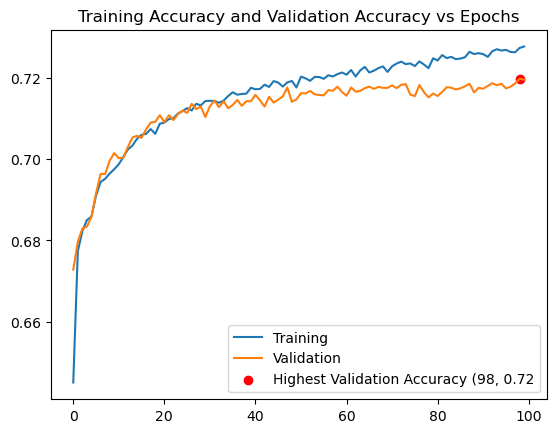

In [25]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
max_point = np.argmax(val_accuracy)

plt.plot(range(len(accuracy)), accuracy, label='Training')
plt.plot(range(len(val_accuracy)), val_accuracy, label='Validation')
plt.scatter(max_point, val_accuracy[max_point], color='red', label=f'Highest Validation Accuracy ({max_point}, {round(val_accuracy[max_point], 3)}')
plt.legend()
plt.title('Training Accuracy and Validation Accuracy vs Epochs')
plt.show()

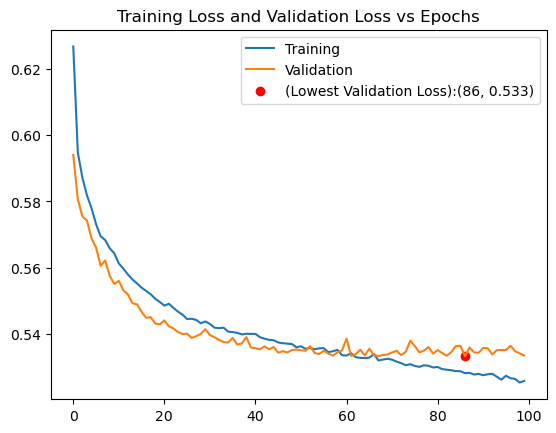

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
min_point = np.argmin(val_loss)

plt.plot(range(len(loss)), loss, label='Training')
plt.plot(range(len(val_loss)), val_loss, label='Validation')
plt.scatter(min_point, val_loss[min_point], color='red', label=f'(Lowest Validation Loss):({min_point}, {round(val_loss[min_point], 3)})')
plt.legend()
plt.title('Training Loss and Validation Loss vs Epochs')
plt.show()

### Input model 8: CNN model

We use a CNN to take into account the spatial structure of the orderbook.

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LeakyReLU, Concatenate, MaxPooling1D

In [28]:
p = 0.2
def create_conv_layers(input_layer):
    # Convolutional layers
    conv1 = Conv1D(filters=16, kernel_size=2)(input_layer)
    conv1 = Dropout(p)(conv1)
    conv1 = LeakyReLU(alpha=0.01)(conv1)
    conv1 = Dropout(p)(conv1)

    return conv1

def create_inception_module(input_layer):
    # Convolutional branches with different kernel sizes
    branch_1 = Conv1D(filters=32, kernel_size=1, padding='same', activation='relu')(input_layer)
    branch_2 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(input_layer)
    branch_3 = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')(input_layer)

    # MaxPooling branch
    branch_4 = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_layer)
    branch_4 = Conv1D(filters=32, kernel_size=1, padding='same', activation='relu')(branch_4)

    # Add dropout
    branch_1 = Dropout(p)(branch_1)
    branch_2 = Dropout(p)(branch_2)
    branch_3 = Dropout(p)(branch_3)
    branch_4 = Dropout(p)(branch_4)

    output = Concatenate(axis=-1)([branch_1, branch_2, branch_3, branch_4])

    return output

def create_model(input_shape):
    # Input layer
    input_layer = Input(shape=input_shape)

    # Create convolutional layers
    conv_layers = create_conv_layers(input_layer)

    # Create Inception module
    inception_module = create_inception_module(conv_layers)

    # LSTM layer
    lstm_layer = LSTM(64)(inception_module)
    lstm_layer = Dropout(p)(lstm_layer)

    # Output layer
    output_layer = Dense(1, activation='sigmoid')(lstm_layer)  # Binary classification

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [29]:
input_shape = (5, 5)
model_inception = create_model(input_shape)

In [ ]:
history = model_inception.fit(X_train_reshaped, Y_train.astype("float32"), epochs=100, batch_size=256, validation_data=(X_val_reshaped, Y_val.astype("float32")), verbose=True)

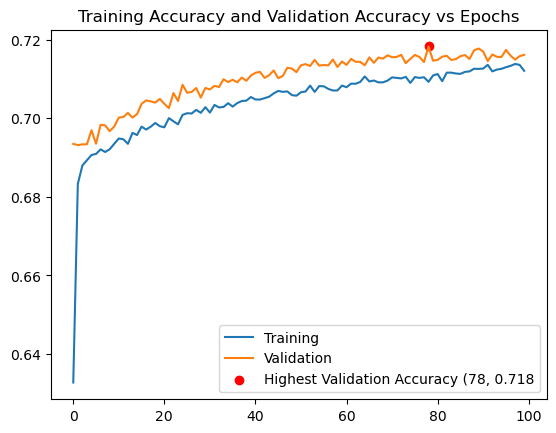

In [31]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
max_point = np.argmax(val_accuracy)

plt.plot(range(len(accuracy)), accuracy, label='Training')
plt.plot(range(len(val_accuracy)), val_accuracy, label='Validation')
plt.scatter(max_point, val_accuracy[max_point], color='red', label=f'Highest Validation Accuracy ({max_point}, {round(val_accuracy[max_point], 3)}')
plt.legend()
plt.title('Training Accuracy and Validation Accuracy vs Epochs')
plt.show()

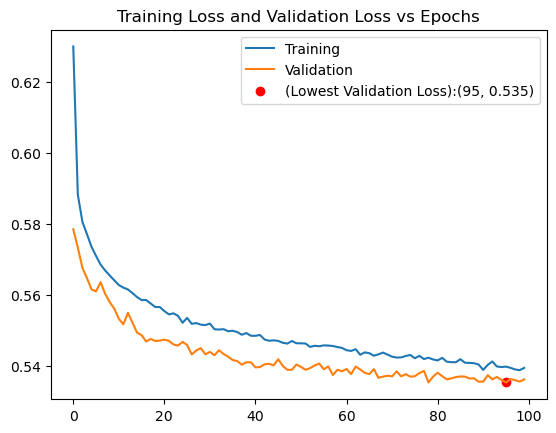

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']
min_point = np.argmin(val_loss)

plt.plot(range(len(loss)), loss, label='Training')
plt.plot(range(len(val_loss)), val_loss, label='Validation')
plt.scatter(min_point, val_loss[min_point], color='red', label=f'(Lowest Validation Loss):({min_point}, {round(val_loss[min_point], 3)})')
plt.legend()
plt.title('Training Loss and Validation Loss vs Epochs')
plt.show()

# Stacking

We will now stack the models for ensemble learning. We use high values of dropout to encourage the ensembling, and we use a small number of parameters to avoid overfitting. We ensemble them for more robust predictions.

In [ ]:
# Make predictions
preds_train_lr = model_lr.predict_proba(X_train)[:,0]
preds_train_rf = model_rf.predict_proba(X_train)[:,0]
# preds_train_knn = model_knn.predict_proba(X_train)[:,0]
# preds_train_nb = model_nb.predict_proba(X_train)[:,0]
preds_train_nn = model_nn_input.predict(X_train).reshape(-1)
preds_train_xgb = model_xgb.predict(X_train)
preds_train_lstm = model_lstm.predict(X_train_reshaped)
preds_train_inception = model_inception.predict(X_train_reshaped)

preds_test_lr = model_lr.predict_proba(X_val)[:,0]
preds_test_rf = model_rf.predict_proba(X_val)[:,0]
# preds_test_knn = model_knn.predict_proba(X_val)[:,0]
# preds_test_nb = model_nb.predict_proba(X_val)[:,0]
preds_test_nn = model_nn_input.predict(X_val).reshape(-1)
preds_test_xgb = model_xgb.predict(X_val)
preds_test_lstm = model_lstm.predict(X_val_reshaped)
preds_test_inception = model_inception.predict(X_val_reshaped)

In [ ]:
# Prepare neural network input
nn_input_train = np.column_stack((preds_train_lr, preds_train_rf, preds_train_nn, preds_train_xgb, preds_train_lstm, preds_train_inception))
nn_input_val = np.column_stack((preds_test_lr, preds_test_rf, preds_test_nn, preds_test_xgb, preds_test_lstm, preds_test_inception))

# Create neural network
model_nn = Sequential([
    Dense(6, activation='tanh', input_shape=(nn_input_train.shape[1],)),
    Dropout(0.9),
    Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network
history1 = model_nn.fit(nn_input_train, Y_train, validation_data=(nn_input_val, Y_val), epochs=25, batch_size=4096, verbose=True)

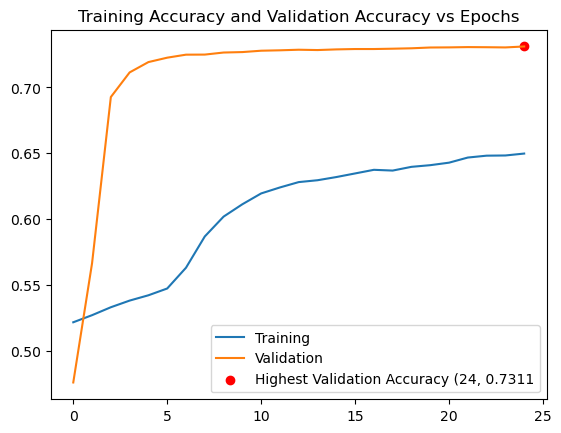

In [35]:
accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
max_point = np.argmax(val_accuracy)


plt.plot(range(len(accuracy)), accuracy, label='Training')
plt.plot(range(len(val_accuracy)), val_accuracy, label='Validation')
plt.scatter(max_point, val_accuracy[max_point], color='red', label=f'Highest Validation Accuracy ({max_point}, {round(val_accuracy[max_point], 4)}')
plt.legend()
plt.title('Training Accuracy and Validation Accuracy vs Epochs')
plt.show()

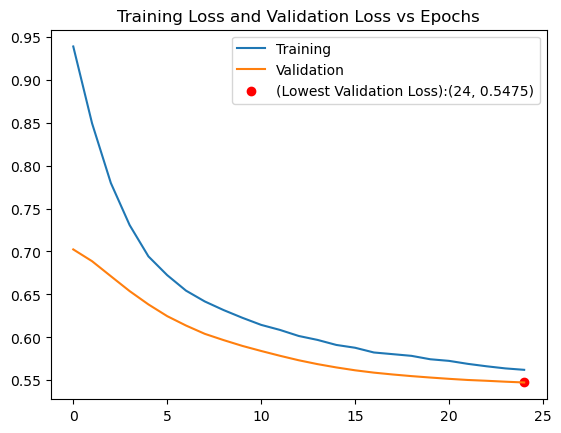

In [36]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']
min_point = np.argmin(val_loss)

plt.plot(range(len(loss)), loss, label='Training')
plt.plot(range(len(val_loss)), val_loss, label='Validation')
plt.scatter(min_point, val_loss[min_point], color='red', label=f'(Lowest Validation Loss):({min_point}, {round(val_loss[min_point], 4)})')
plt.legend()
plt.title('Training Loss and Validation Loss vs Epochs')
plt.show()

# Out of sample testing

We achieve an accuracy of 73% on the test set using ensembling.

In [37]:
model_lr = Pipeline([
    ('logistic', LogisticRegression())
])

# Train the model using the pipeline
model_lr.fit(X_train_large, Y_train_large) 

# Make predictions
predictions_lr = model_lr.predict(X_test)

# Evaluate the model
print(confusion_matrix(Y_test, predictions_lr))
print(classification_report(Y_test, predictions_lr))

[[13492  6493]
 [ 6778 13237]]
              precision    recall  f1-score   support

           0       0.67      0.68      0.67     19985
           1       0.67      0.66      0.67     20015

    accuracy                           0.67     40000
   macro avg       0.67      0.67      0.67     40000
weighted avg       0.67      0.67      0.67     40000



In [38]:
best_n = 500
best_depth = 15

# Retrain the model on the entire training set with the best hyperparameters
model_rf = Pipeline([('rf', RandomForestClassifier(n_estimators=best_n, max_depth = best_depth))])
model_rf.fit(X_train_large, Y_train_large)

# Make predictions
predictions_rf = model_rf.predict(X_test)

# Evaluate the model
print(confusion_matrix(Y_test, predictions_rf))
print(classification_report(Y_test, predictions_rf))

[[14551  5434]
 [ 5355 14660]]
              precision    recall  f1-score   support

           0       0.73      0.73      0.73     19985
           1       0.73      0.73      0.73     20015

    accuracy                           0.73     40000
   macro avg       0.73      0.73      0.73     40000
weighted avg       0.73      0.73      0.73     40000



In [39]:
opti_lr = 0.05623413251903491
opti_n = 500
opti_subsample = 1

model_xgb = xgb.XGBRegressor(learning_rate = opti_lr, n_estimators = opti_n, subsample = opti_subsample, random_state = 1).fit(X_train_large, Y_train_large)

# Make predictions
predictions_xgb = model_xgb.predict(X_test)
predictions_xgb[predictions_xgb > 0.5 ] = int(1)
predictions_xgb[predictions_xgb <= 0.5 ] = int(0)  


# Evaluate the model
print("Accuracy:", accuracy_score(Y_test, predictions_xgb))
print(classification_report(Y_test, predictions_xgb))

Accuracy: 0.72955
              precision    recall  f1-score   support

           0       0.73      0.73      0.73     19985
           1       0.73      0.73      0.73     20015

    accuracy                           0.73     40000
   macro avg       0.73      0.73      0.73     40000
weighted avg       0.73      0.73      0.73     40000



In [ ]:
#retrain the model
opti_epoch = 178
opti_acti = ['relu', 'sigmoid']
opti_dropout = 0.2

# Select the optimal epoch
model_nn_input = Sequential([
        Dense(128, activation= opti_acti[0], input_shape=(X_train.shape[1],)),
        Dropout(opti_dropout),
        Dense(128, activation= opti_acti[1]),
        Dropout(opti_dropout),
        Dense(1, activation='sigmoid')
    ])

model_nn_input.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the neural network
history = model_nn_input.fit(X_train_large, Y_train_large, validation_data=(X_test,Y_test), epochs= opti_epoch, batch_size=256, verbose=True)

In [ ]:
model_lstm = Sequential([
    Masking(mask_value=0., input_shape=(5, 5)),
    Bidirectional(LSTM(50, return_sequences=True, activation='tanh')),
    Dropout(0.5),
    LSTM(50, return_sequences=False, activation='tanh'),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

partitioned_x_train_large = partition_features(X_train_large)
partitioned_x_test = partition_features(X_test)

X_train_large_reshaped = get_sequences(partitioned_x_train_large)
X_test_reshaped = get_sequences(partitioned_x_test)

history = model_lstm.fit(X_train_large_reshaped, Y_train_large.astype("float32"), epochs=100, batch_size=256, validation_data=(X_test_reshaped, Y_test.astype("float32")), verbose=True)

In [ ]:
input_shape = (5, 5)  # 100 timesteps, 40 features
model_inception = create_model(input_shape)

history = model_inception.fit(X_train_large_reshaped, Y_train_large.astype("float32"), epochs=100, batch_size=256, validation_data=(X_test_reshaped, Y_test.astype("float32")), verbose=True)

In [43]:
# Ensemble
preds_train_lr = model_lr.predict_proba(X_train_large)[:,0]
preds_train_rf = model_rf.predict_proba(X_train_large)[:,0]
preds_train_nn = model_nn_input.predict(X_train_large).reshape(-1)
preds_train_xgb = model_xgb.predict(X_train_large)
preds_train_lstm = model_lstm.predict(X_train_large_reshaped)
preds_train_inception = model_inception.predict(X_train_large_reshaped)

preds_test_lr = model_lr.predict_proba(X_test)[:,0]
preds_test_rf = model_rf.predict_proba(X_test)[:,0]
preds_test_nn = model_nn_input.predict(X_test).reshape(-1)
preds_test_xgb = model_xgb.predict(X_test)
preds_test_lstm = model_lstm.predict(X_test_reshaped)
preds_test_inception = model_inception.predict(X_test_reshaped)

1250/1250 [==============================] - 2s 2ms/step


In [ ]:
# Prepare neural network input
nn_input_train = np.column_stack((preds_train_lr, preds_train_rf, preds_train_nn, preds_train_xgb, preds_train_lstm, preds_train_inception))
nn_input_test = np.column_stack((preds_test_lr, preds_test_rf, preds_test_nn, preds_test_xgb, preds_test_lstm, preds_test_inception))

# Create neural network
model_nn = Sequential([
    Dense(6, activation='tanh', input_shape=(nn_input_train.shape[1],)),
    Dropout(0.9),
    Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network
history1 = model_nn.fit(nn_input_train, Y_train_large, validation_data=(nn_input_test, Y_test), epochs=25, batch_size=4096, verbose=True)

# Making our submission

In [45]:
model_lr = Pipeline([
    ('logistic', LogisticRegression())
])

# Train the model using the pipeline
model_lr.fit(X, Y)

Pipeline(steps=[('logistic', LogisticRegression())])

In [46]:
best_n = 500
best_depth = 15

# Retrain the model on the entire training set with the best hyperparameters
model_rf = Pipeline([('rf', RandomForestClassifier(n_estimators=best_n, max_depth = best_depth))])
model_rf.fit(X, Y)

Pipeline(steps=[('rf', RandomForestClassifier(max_depth=15, n_estimators=500))])

In [47]:
opti_lr = 0.05623413251903491
opti_n = 500
opti_subsample = 1

model_xgb = xgb.XGBRegressor(learning_rate = opti_lr, n_estimators = opti_n, subsample = opti_subsample, random_state = 1).fit(X, Y)

In [ ]:
#retrain the model
opti_epoch = 178
opti_acti = ['relu', 'sigmoid']
opti_dropout = 0.2

# Select the optimal epoch
model_nn_input = Sequential([
        Dense(128, activation= opti_acti[0], input_shape=(X_train.shape[1],)),
        Dropout(opti_dropout),
        Dense(128, activation= opti_acti[1]),
        Dropout(opti_dropout),
        Dense(1, activation='sigmoid')
    ])

model_nn_input.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network
history = model_nn_input.fit(X, Y, epochs=opti_epoch, batch_size=256, verbose=True)

In [49]:
partitioned_x_A = partition_features(X)
partitioned_x_B = partition_features(X_B)

X_reshaped = get_sequences(partitioned_x_A)
X_B_reshaped = get_sequences(partitioned_x_B)

In [ ]:
model_lstm = Sequential([
    Masking(mask_value=0., input_shape=(5, 5)),
    Bidirectional(LSTM(50, return_sequences=True, activation='tanh')),
    Dropout(0.5),
    LSTM(50, return_sequences=False, activation='tanh'),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid'),
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_lstm.fit(X_reshaped, Y.astype("float32"), epochs=100, batch_size=256, verbose=True)

In [ ]:
input_shape = (5, 5)  # 100 timesteps, 40 features
model_inception = create_model(input_shape)

history = model_inception.fit(X_reshaped, Y.astype("float32"), epochs=100, batch_size=256, verbose=True)

In [52]:
# Ensemble
preds_train_lr = model_lr.predict_proba(X)[:,0]
preds_train_rf = model_rf.predict_proba(X)[:,0]
preds_train_nn = model_nn_input.predict(X).reshape(-1)
preds_train_xgb = model_xgb.predict(X)
preds_train_lstm = model_lstm.predict(X_reshaped)
preds_train_inception = model_inception.predict(X_reshaped)

preds_test_lr = model_lr.predict_proba(X_B)[:,0]
preds_test_rf = model_rf.predict_proba(X_B)[:,0]
preds_test_nn = model_nn_input.predict(X_B).reshape(-1)
preds_test_xgb = model_xgb.predict(X_B)
preds_test_lstm = model_lstm.predict(X_B_reshaped)
preds_test_inception = model_inception.predict(X_B_reshaped)

625/625 [==============================] - 2s 3ms/step


In [ ]:
# Prepare neural network input
nn_input_train = np.column_stack((preds_train_lr, preds_train_rf, preds_train_nn, preds_train_xgb, preds_train_lstm, preds_train_inception))
nn_input_test = np.column_stack((preds_test_lr, preds_test_rf, preds_test_nn, preds_test_xgb, preds_test_lstm, preds_test_inception))

# Create neural network
model_nn = Sequential([
    Dense(6, activation='tanh', input_shape=(nn_input_train.shape[1],)),
    Dropout(0.9),
    Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network
history1 = model_nn.fit(nn_input_train, Y, epochs=25, batch_size=4096, verbose=True)

In [54]:
prediction = model_nn.predict(nn_input_test)

625/625 [==============================] - 0s 493us/step


In [55]:
classification = np.round(prediction).astype(int)